<a href="https://colab.research.google.com/github/yudhaerian/UAS_BigData/blob/main/UasBigData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**UAS BIG DATA**
Moch Yudha Erian Saputra (2041723011)

**Data set Team Football 2020**

In [1]:
#instal required libraries

In [2]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import wget

In [4]:
#Download dataset 
link_to_data = 'https://github.com/tulip-lab/sit742/raw/master/Assessment/2020/data/2020T2Data.csv'
DataSet = wget.download(link_to_data)

In [5]:
DataSet

'2020T2Data (5).csv'

In [6]:
#install pyspark

In [7]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
#1.1 Data Exploration

In [9]:
#import required libraries
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

In [10]:
#Create sparksession
spark = (SparkSession
 .builder
 .appName('SIT742T2')
 .enableHiveSupport()
 .getOrCreate())

In [11]:
#Reading csv file as a spark dataframe

In [12]:
df = spark.read.csv('2020T2Data.csv',inferSchema = True,header=True)

In [13]:
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Photo: string (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- Flag: string (nullable = true)
 |-- Overall: integer (nullable = true)
 |-- Potential: integer (nullable = true)
 |-- Club: string (nullable = true)
 |-- Club Logo: string (nullable = true)
 |-- value(M): string (nullable = true)
 |-- wage(K): integer (nullable = true)
 |-- Special: integer (nullable = true)
 |-- Preferred Foot: string (nullable = true)
 |-- International Reputation: integer (nullable = true)
 |-- Weak Foot: integer (nullable = true)
 |-- Skill Moves: integer (nullable = true)
 |-- Work Rate: string (nullable = true)
 |-- Body Type: string (nullable = true)
 |-- Real Face: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Jersey Number: integer (nullable = true)
 |-- Joined: string (nullable = true)
 |-- Loaned From: string (nullable = true)
 |-- Contract 

In [14]:
df.columns

['ID',
 'Name',
 'Age',
 'Photo',
 'Nationality',
 'Flag',
 'Overall',
 'Potential',
 'Club',
 'Club Logo',
 'value(M)',
 'wage(K)',
 'Special',
 'Preferred Foot',
 'International Reputation',
 'Weak Foot',
 'Skill Moves',
 'Work Rate',
 'Body Type',
 'Real Face',
 'Position',
 'Jersey Number',
 'Joined',
 'Loaned From',
 'Contract Valid Until',
 'Height',
 'Height(CM)',
 'Weight',
 'Weight(KG)',
 'Crossing',
 'Finishing',
 'HeadingAccuracy',
 'ShortPassing',
 'Volleys',
 'Dribbling',
 'Curve',
 'FKAccuracy',
 'LongPassing',
 'BallControl',
 'Acceleration',
 'SprintSpeed',
 'Agility',
 'Reactions',
 'Balance',
 'ShotPower',
 'Jumping',
 'Stamina',
 'Strength',
 'LongShots',
 'Aggression',
 'Interceptions',
 'Positioning',
 'Vision',
 'Penalties',
 'Composure',
 'Marking',
 'StandingTackle',
 'SlidingTackle',
 'GKDiving',
 'GKHandling',
 'GKKicking',
 'GKPositioning',
 'GKReflexes',
 'Release Clause(M)']

In [15]:
df.show(5)

+------+-----------------+---+--------------------+-----------+--------------------+-------+---------+-------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+----------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+
|    ID|             Name|Age|               Photo|Nationality|                Flag|Overall|Potential|               Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|     Work Rate| Body 

In [16]:
#Which are the (min, mean and max) for Age

In [17]:
from pyspark.sql import functions as F

import pyspark.sql.functions as F


#Statistics on Age 
print("Minimum of Age :")
df.select(F.min('Age')).show()


print("Mean of Age :")
df.select(F.mean('Age')).show()

print("Maximum of Age :")
df.select(F.max('Age')).show()


Minimum of Age :
+--------+
|min(Age)|
+--------+
|      16|
+--------+

Mean of Age :
+------------------+
|          avg(Age)|
+------------------+
|25.122205745043114|
+------------------+

Maximum of Age :
+--------+
|max(Age)|
+--------+
|      45|
+--------+



In [18]:
#minimum age is 16, mean of age is 25.122205.., maximum age is 45

In [19]:
#Which are the (min, mean and max) for Overall

In [20]:

#Statistics on Overall 

print("Minimum of Overall :")
df.select(F.min('Overall')).show()


print("Mean of Overall :")
df.select(F.mean('Overall')).show()

print("Maximum of Overall :")
df.select(F.max('Overall')).show()

Minimum of Overall :
+------------+
|min(Overall)|
+------------+
|          46|
+------------+

Mean of Overall :
+-----------------+
|     avg(Overall)|
+-----------------+
|66.23869940132916|
+-----------------+

Maximum of Overall :
+------------+
|max(Overall)|
+------------+
|          94|
+------------+



In [21]:
#minimum overall is 46, mean of overall is 66.23869940.. and maximum overall is 94

In [22]:
#Find the position having highest Avg Overall (sort Avg Overall by position)

In [23]:
df.groupBy("Position").agg(F.mean('Overall')).orderBy("avg(Overall)", ascending=False).show(10)

+--------+-----------------+
|Position|     avg(Overall)|
+--------+-----------------+
|      LF|73.86666666666666|
|      RF|            73.25|
|     RAM|72.28571428571429|
|     LAM|71.85714285714286|
|      LS|70.06280193236715|
|     RDM|69.75403225806451|
|      RS|69.52216748768473|
|     RCB|69.28398791540785|
|     LCM|69.27088607594936|
|     LCB|69.24074074074075|
+--------+-----------------+
only showing top 10 rows



In [24]:
#So position "LF" have highest avg(Overall)

In [25]:
#Find the top 3 countries with highest Avg Overall (sort Avg Overall by countries)

In [26]:
df.groupBy("Nationality").agg(F.mean('Overall')).orderBy("avg(Overall)", ascending=False).show(3)

+--------------------+-----------------+
|         Nationality|     avg(Overall)|
+--------------------+-----------------+
|United Arab Emirates|             77.0|
|Central African Rep.|73.33333333333333|
|              Israel|72.14285714285714|
+--------------------+-----------------+
only showing top 3 rows



In [27]:
#So the top 3 countries with highest Avg overall are "United Arab Emirates","Central American Rep." and "Israel"

In [28]:


#1.1.B



In [29]:
#Show the results on Avg Potentials on Country by Position with ordering the results on country by alphabet

In [30]:
#Your code for the results on Avg Potentials on Country by Position with ordering the results on country by alphabet (show top 10)

df1 = df.groupBy("Nationality","Position").agg(F.mean('Potential')).orderBy("Nationality",descending=False)
df1.show(10)

+-----------+--------+-----------------+
|Nationality|Position|   avg(Potential)|
+-----------+--------+-----------------+
|Afghanistan|     CAM|             66.0|
|Afghanistan|      CM|             71.0|
|Afghanistan|      LM|             70.0|
|Afghanistan|      LB|             64.0|
|    Albania|      LB|             66.0|
|    Albania|     RCB|             68.0|
|    Albania|     CDM|             69.5|
|    Albania|      CB|74.33333333333333|
|    Albania|      GK|             77.5|
|    Albania|      RM|             64.0|
+-----------+--------+-----------------+
only showing top 10 rows



In [31]:
#Find position having highest Avg Potential for Australia

In [32]:
#Your Code to identify the position having highest Avg Potential for Australia

df1.filter((df1.Nationality=="Australia")).orderBy("avg(Potential)",ascending=False).show(5)

+-----------+--------+-----------------+
|Nationality|Position|   avg(Potential)|
+-----------+--------+-----------------+
|  Australia|     RDM|             77.0|
|  Australia|     RCM|             72.5|
|  Australia|     CAM|            71.25|
|  Australia|     LWB|             71.0|
|  Australia|      RM|70.53846153846153|
+-----------+--------+-----------------+
only showing top 5 rows



In [33]:
#So Position with Highest average potential for Australia is "RDM"

In [34]:
#is there a age that the player is fully released his potential? If there is, could you find out?

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [36]:
X = df.groupBy("Age").agg(F.mean('Potential'))

In [37]:
X.show(100)

+---+-----------------+
|Age|   avg(Potential)|
+---+-----------------+
| 31|69.85007072135785|
| 34|69.53960396039604|
| 28| 69.4441416893733|
| 26|70.17664023071377|
| 27| 69.7091222030981|
| 22|72.81940298507463|
| 16|73.19047619047619|
| 40| 67.6923076923077|
| 20|73.21370967741936|
| 19|     73.146484375|
| 41|             67.6|
| 37| 68.9390243902439|
| 17|74.33910034602076|
| 35|68.13265306122449|
| 23|72.55555555555556|
| 39|            67.64|
| 45|             71.0|
| 38|67.37837837837837|
| 25|71.29037149355572|
| 24|72.07952871870398|
| 29|69.35766423357664|
| 21|72.95783555867885|
| 32|69.52961672473867|
| 33|69.55882352941177|
| 42|             65.0|
| 30|69.70010905125409|
| 18|73.53005464480874|
| 36|67.93700787401575|
| 44|             50.5|
+---+-----------------+



In [38]:
age =[31,34,28,26,27,44,22,16,40,20,19,41,37,17,35,23,39,45,38,25,24,29,21,32,33,42,30,18,36]
avg_pot = [69.85007072135785, 69.53960396039604, 69.4441416893733, 70.17664023071377, 69.7091222030981, 50.5, 72.81940298507463, 73.19047619047619,
                 67.6923076923077, 73.21370967741936, 73.146484375, 67.6, 68.9390243902439, 74.33910034602076, 68.13265306122449, 72.55555555555556, 67.64,
                 71.0, 67.37837837837837, 71.29037149355572, 72.07952871870398, 69.35766423357664, 72.95783555867885, 69.52961672473867,
                 69.55882352941177, 65.0, 69.70010905125409, 73.53005464480874, 67.93700787401575]

In [39]:
len(age), len(avg_pot)

(29, 29)

In [40]:
d = {'Age': age,'avg(Potential)': avg_pot}
dss = pd.DataFrame(d)

In [41]:
dss.sort_values(by=['Age'], inplace=True)
dss

,Age,avg(Potential)
7,16,73.190476
13,17,74.339100
27,18,73.530055
10,19,73.146484
9,20,73.213710
22,21,72.957836
6,22,72.819403
15,23,72.555556
20,24,72.079529
19,25,71.290371


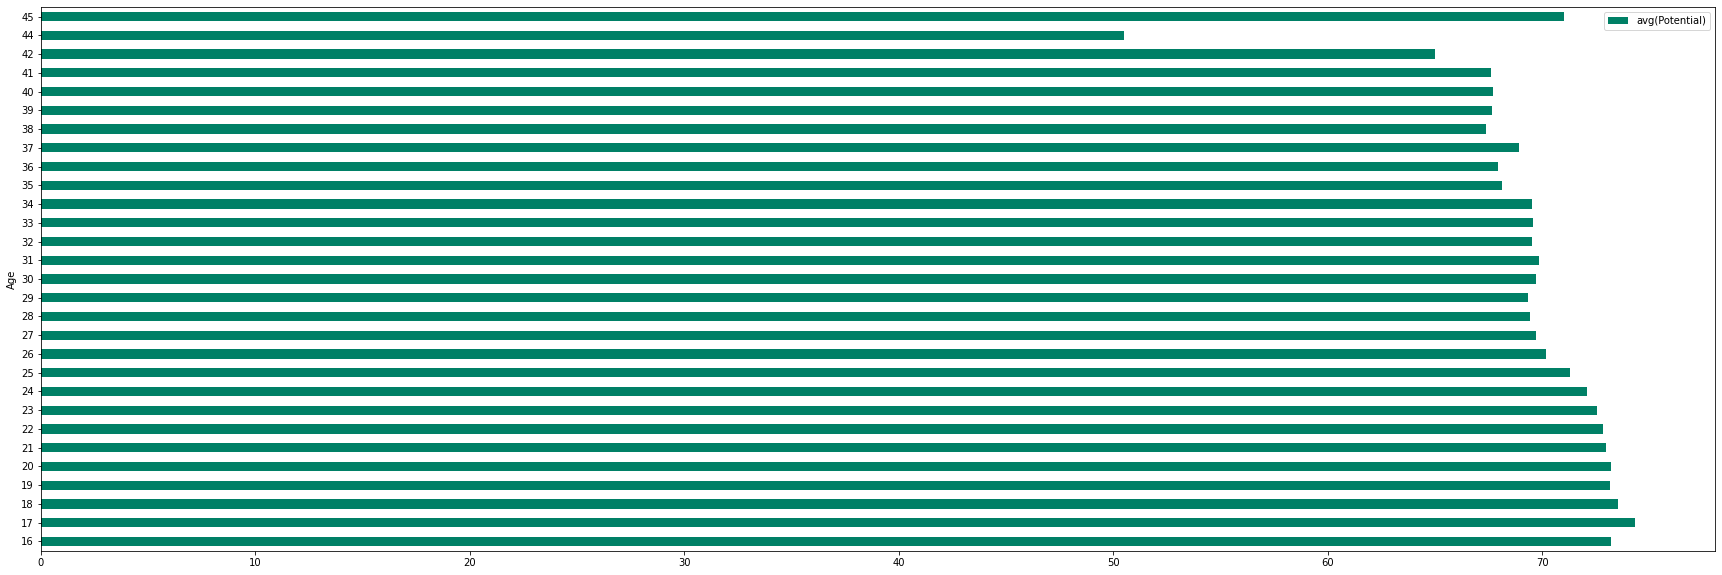

In [42]:
dss.plot(kind='barh',x='Age',y='avg(Potential)',colormap='summer',figsize = (30,10))
plt.show()

In [43]:
Y = df.groupBy("Age").agg(F.mean('Overall'))

In [44]:
Y.show(30)

+---+------------------+
|Age|      avg(Overall)|
+---+------------------+
| 31| 69.85007072135785|
| 34| 69.53960396039604|
| 28| 69.21344232515895|
| 26| 68.51478010093727|
| 27| 68.94922547332186|
| 22| 64.99402985074627|
| 16| 54.45238095238095|
| 40|  67.6923076923077|
| 20|61.858870967741936|
| 19|     59.5830078125|
| 41|              67.6|
| 37|  68.9390243902439|
| 17| 56.40484429065744|
| 35| 68.13265306122449|
| 23| 66.24474474474475|
| 39|             67.64|
| 45|              71.0|
| 38| 67.37837837837837|
| 25| 67.97346474601972|
| 24| 67.30633284241532|
| 29|  69.2460896767466|
| 21| 63.48067463106114|
| 32| 69.52961672473867|
| 33| 69.55882352941177|
| 42|              65.0|
| 30| 69.69574700109051|
| 18| 57.74180327868852|
| 36| 67.93700787401575|
| 44|              50.5|
+---+------------------+



In [45]:
avg_ovr = [69.85007072135785, 69.53960396039604, 69.21344232515895, 68.51478010093727, 68.94922547332186, 50.5, 64.99402985074627, 54.45238095238095,
          67.6923076923077, 61.858870967741936, 59.5830078125, 67.6, 68.9390243902439, 56.40484429065744, 68.13265306122449, 66.24474474474475, 67.64,
          71.0, 67.37837837837837, 67.97346474601972, 67.30633284241532, 69.2460896767466, 63.48067463106114, 69.52961672473867, 69.55882352941177,65.0,
          69.69574700109051, 57.74180327868852, 67.93700787401575]
len(avg_ovr)

29

In [46]:
d = {'Age': age,'avg(Overall)': avg_ovr}
ds = pd.DataFrame(d)

In [47]:
ds.sort_values(by=['Age'], inplace=True)
ds

,Age,avg(Overall)
7,16,54.452381
13,17,56.404844
27,18,57.741803
10,19,59.583008
9,20,61.858871
22,21,63.480675
6,22,64.994030
15,23,66.244745
20,24,67.306333
19,25,67.973465


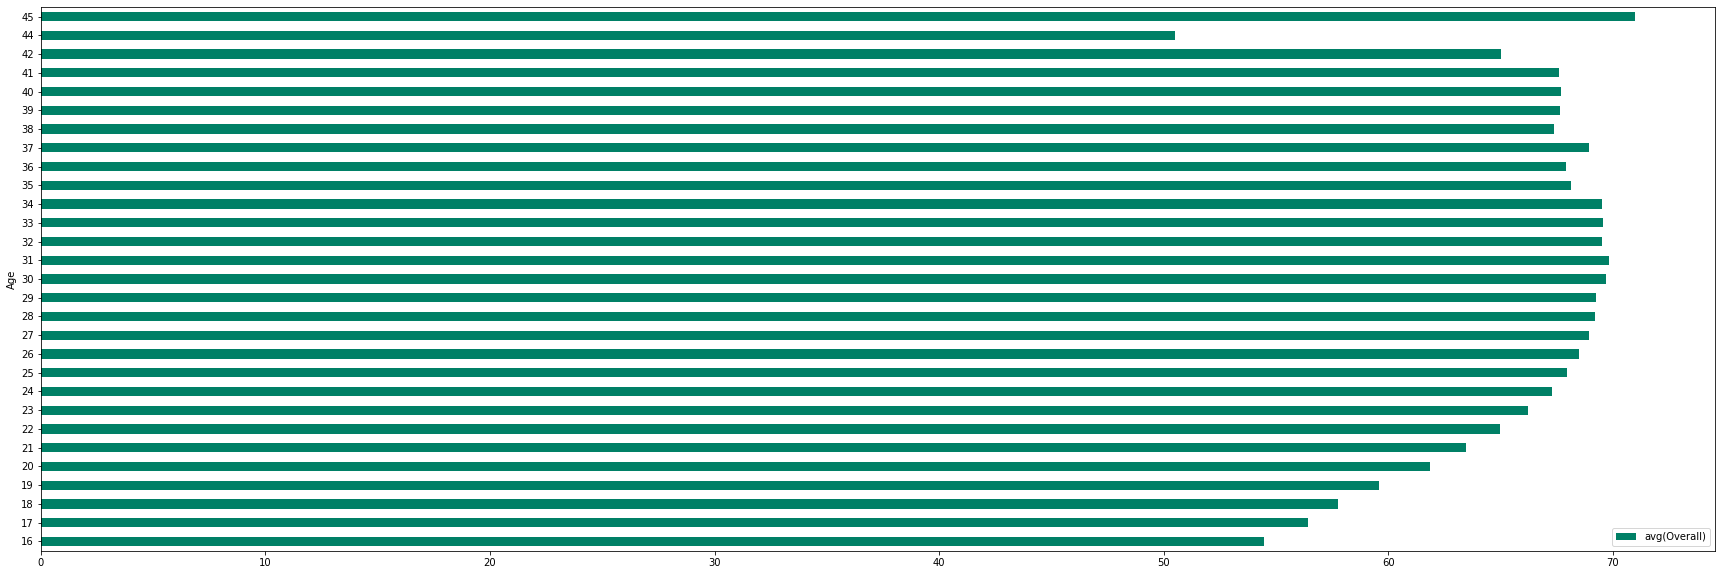

In [48]:
ds.plot(kind='barh',x='Age',y='avg(Overall)',colormap='summer',figsize = (30,10))
plt.show()

In [49]:
dff = pd.DataFrame(dss['avg(Potential)'] - ds['avg(Overall)'])
dff['Age'] = ds['Age']
dff

,0,Age
7,18.738095,16
13,17.934256,17
27,15.788251,18
10,13.563477,19
9,11.354839,20
22,9.477161,21
6,7.825373,22
15,6.310811,23
20,4.773196,24
19,3.316907,25


In [50]:
# So at age of 31,32,33....42,44,45 players fully released their potential

In [51]:
# Part 2 - Unsupervised Learning: Kmeans

In [52]:
#DATA PREPARATION

In [53]:
#code to select relevant features and filter the data by removing the GK

In [54]:
df2 = df.select('ID','Position', 'Height(CM)', 'Weight(KG)', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 
           'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 
           'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle')
df2.show(3)
df2 = df2.filter((df.Position != "GK"))
df2.show(5)

+------+--------+----------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+
|    ID|Position|Height(CM)|Weight(KG)|Crossing|Finishing|HeadingAccuracy|ShortPassing|Volleys|Dribbling|Curve|FKAccuracy|LongPassing|BallControl|Acceleration|SprintSpeed|Agility|Reactions|Balance|ShotPower|Jumping|Stamina|Strength|LongShots|Aggression|Interceptions|Positioning|Vision|Penalties|Composure|Marking|StandingTackle|SlidingTackle|
+------+--------+----------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+------

In [55]:
df2.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Position: string (nullable = true)
 |-- Height(CM): double (nullable = true)
 |-- Weight(KG): double (nullable = true)
 |-- Crossing: integer (nullable = true)
 |-- Finishing: integer (nullable = true)
 |-- HeadingAccuracy: integer (nullable = true)
 |-- ShortPassing: integer (nullable = true)
 |-- Volleys: integer (nullable = true)
 |-- Dribbling: integer (nullable = true)
 |-- Curve: integer (nullable = true)
 |-- FKAccuracy: integer (nullable = true)
 |-- LongPassing: integer (nullable = true)
 |-- BallControl: integer (nullable = true)
 |-- Acceleration: integer (nullable = true)
 |-- SprintSpeed: integer (nullable = true)
 |-- Agility: integer (nullable = true)
 |-- Reactions: integer (nullable = true)
 |-- Balance: integer (nullable = true)
 |-- ShotPower: integer (nullable = true)
 |-- Jumping: integer (nullable = true)
 |-- Stamina: integer (nullable = true)
 |-- Strength: integer (nullable = true)
 |-- LongShots: integer (nullable =

In [56]:
from pyspark.sql.functions import when,col

# Your code to complete
DEF=  ['LB','LWB','RB','LCB','RCB','CB','RWB']
FWD=   ['RF','LF','LW','RS','RW','LS','CF','ST']
MID=  ['LCM','LM','RDM','CAM','RAM','RCM','CM','CDM','RM','LAM','LDM']


# code here to create a new variable df_kmeans_new with a new column Position_Group, ..


df_kmeans_new = df2.withColumn(
    'Position_Group',
    F.when((F.col("Position") == 'LB') | (F.col("Position") == 'LWB') | (F.col("Position") == 'RB') | (F.col("Position") == 'LCB') | (F.col("Position") == 'RCB') | (F.col("Position") == 'CB') | (F.col("Position") == 'RWB'), 'DEF')\
    .when((F.col("Position") == 'RF') | (F.col("Position") == 'LF') | (F.col("Position") == 'LW') | (F.col("Position") == 'RS') | (F.col("Position") == 'RW') | (F.col("Position") == 'LS') | (F.col("Position") == 'CF') | (F.col("Position") == 'ST'), 'FWD')\
    .otherwise('MID')
)
df_kmeans_new.show(3)

+------+--------+----------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------------+
|    ID|Position|Height(CM)|Weight(KG)|Crossing|Finishing|HeadingAccuracy|ShortPassing|Volleys|Dribbling|Curve|FKAccuracy|LongPassing|BallControl|Acceleration|SprintSpeed|Agility|Reactions|Balance|ShotPower|Jumping|Stamina|Strength|LongShots|Aggression|Interceptions|Positioning|Vision|Penalties|Composure|Marking|StandingTackle|SlidingTackle|Position_Group|
+------+--------+----------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+---

In [57]:
df_kmeans_new.groupBy('Height(CM)').count().show(100)

+----------+-----+
|Height(CM)|count|
+----------+-----+
|   158.496|    5|
|   195.072|  457|
|   173.736|  903|
|   170.688|  316|
|   161.544|   18|
|   207.264|    3|
|   179.832| 2226|
|   185.928| 1588|
|   201.168|   42|
|   204.216|   12|
|    182.88| 2609|
|   155.448| 2447|
|   188.976| 1531|
|    198.12|  133|
|   176.784|  942|
|   164.592|   30|
|    167.64|  145|
|   192.024|  661|
|  155.7528| 2054|
+----------+-----+



In [58]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

FEATURES_COL = ['Height(CM)', 'Weight(KG)', 
                      'Crossing', 'Finishing', 'HeadingAccuracy', 
                      'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
                      'FKAccuracy', 'LongPassing', 'BallControl', 
                      'Acceleration', 'SprintSpeed', 'Agility', 
                      'Reactions', 'Balance', 'ShotPower', 'Jumping', 
                      'Stamina', 'Strength', 'LongShots', 'Aggression', 
                      'Interceptions', 'Positioning', 'Vision', 'Penalties', 
                      'Composure', 'Marking', 'StandingTackle', 'SlidingTackle']

vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
df_kmeans_ = vecAssembler.transform(df_kmeans_new).select('ID','features')
df_kmeans_.show(3)

+------+--------------------+
|    ID|            features|
+------+--------------------+
|158023|[173.736,72.12112...|
| 20801|[188.976,83.00733...|
|190871|[179.832,68.0388,...|
+------+--------------------+
only showing top 3 rows



In [59]:
import pyspark.sql.functions as f
m = df_kmeans_.select(f.collect_list('ID')).first()[0]
n = df_kmeans_.select(f.collect_list('features')).first()[0]

In [60]:
ss = df_kmeans_new.select(['Height(CM)', 'Weight(KG)', 
                      'Crossing', 'Finishing', 'HeadingAccuracy', 
                      'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
                      'FKAccuracy', 'LongPassing', 'BallControl', 
                      'Acceleration', 'SprintSpeed', 'Agility', 
                      'Reactions', 'Balance', 'ShotPower', 'Jumping', 
                      'Stamina', 'Strength', 'LongShots', 'Aggression', 
                      'Interceptions', 'Positioning', 'Vision', 'Penalties', 
                      'Composure', 'Marking', 'StandingTackle', 'SlidingTackle'])

In [61]:
ss.show(3)

+----------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+
|Height(CM)|Weight(KG)|Crossing|Finishing|HeadingAccuracy|ShortPassing|Volleys|Dribbling|Curve|FKAccuracy|LongPassing|BallControl|Acceleration|SprintSpeed|Agility|Reactions|Balance|ShotPower|Jumping|Stamina|Strength|LongShots|Aggression|Interceptions|Positioning|Vision|Penalties|Composure|Marking|StandingTackle|SlidingTackle|
+----------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+
|   173.736| 72.

In [62]:
#Elbow plot

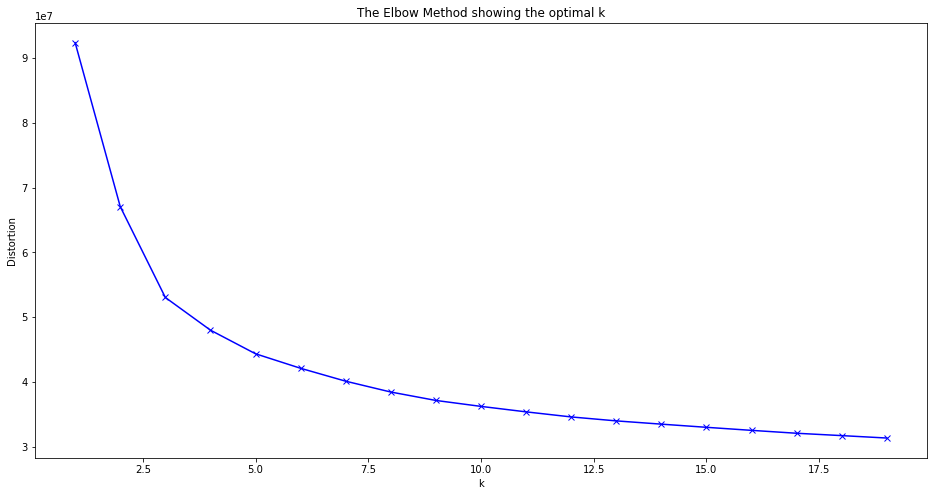

In [63]:
from sklearn.cluster import KMeans

distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(n)
    distortions.append(kmeanModel.inertia_)
    

    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [64]:
#Optimized value of k is 10

In [65]:
#For K = 8

In [66]:
l = df_kmeans_new.select(f.collect_list('Position_Group')).first()[0]
m = df_kmeans_new.select(f.collect_list('Height(CM)')).first()[0]

n = df_kmeans_new.select(f.collect_list('Weight(KG)')).first()[0]

In [67]:
X = pd.DataFrame({'Group' : l, 'Height' : m, 'Weight' : n})

In [68]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

X['Group'] = le.fit_transform(X.Group.values)
print(X)

       Group    Height     Weight
0          1  173.7360  72.121128
1          1  188.9760  83.007336
2          1  179.8320  68.038800
3          2  155.7528  69.853168
4          1  176.7840  73.935496
...      ...       ...        ...
16117      2  179.8320  60.781328
16118      1  192.0240  77.110640
16119      1  176.7840  67.131616
16120      1  155.4480  69.853168
16121      2  155.4480  79.832192

[16122 rows x 3 columns]


[5 2 5 ... 5 6 1]


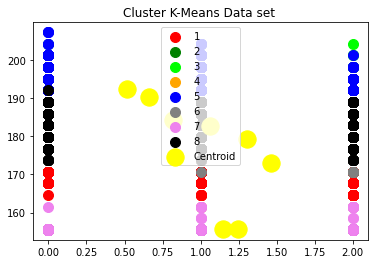

In [69]:
from sklearn.cluster import KMeans
# Applying k-means to the dataset
kmeans = KMeans(n_clusters=8,init='k-means++',max_iter=300,n_init=10,random_state=0) 
y_kmeans = kmeans.fit_predict(X)

print(y_kmeans)

X = X.values

# Visualising the clusters
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0,1],s=100,c='red',label='1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1,1],s=100,c='green',label='2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2,1],s=100,c='lime',label='3')
plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3,1],s=100,c='orange',label='4')
plt.scatter(X[y_kmeans == 4, 0], X[y_kmeans == 4,1],s=100,c='blue',label='5')
plt.scatter(X[y_kmeans == 5, 0], X[y_kmeans == 5,1],s=100,c='gray',label='6')
plt.scatter(X[y_kmeans == 6, 0], X[y_kmeans == 6,1],s=100,c='violet',label='7')
plt.scatter(X[y_kmeans == 7, 0], X[y_kmeans == 7,1],s=100,c='black',label='8')
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],s=300,c='yellow',label='Centroid')
plt.title('Cluster K-Means Data set ')
plt.legend()

plt.show()

In [70]:
#Part 3 - Supervised Learning: Classification on Position_Group

In [71]:
#3.1 Data Preparation

In [72]:
FEATURES_COL_ = ['Height(CM)', 'Weight(KG)', 
                      'Crossing', 'Finishing', 'HeadingAccuracy', 
                      'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
                      'FKAccuracy', 'LongPassing', 'BallControl', 
                      'Acceleration', 'SprintSpeed', 'Agility', 
                      'Reactions', 'Balance', 'ShotPower', 'Jumping', 
                      'Stamina', 'Strength', 'LongShots', 'Aggression', 
                      'Interceptions', 'Positioning', 'Vision', 'Penalties', 
                      'Composure', 'Marking', 'StandingTackle', 'SlidingTackle']


vecAssembler_ = VectorAssembler(inputCols=FEATURES_COL_, outputCol="features")
df_class_ = vecAssembler_.transform(df_kmeans_new).select('features','Position_Group')
df_class_.show(3)

+--------------------+--------------+
|            features|Position_Group|
+--------------------+--------------+
|[173.736,72.12112...|           FWD|
|[188.976,83.00733...|           FWD|
|[179.832,68.0388,...|           FWD|
+--------------------+--------------+
only showing top 3 rows



In [73]:
from pyspark.ml.feature import StandardScaler

standardscaler=StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
raw_data=standardscaler.fit(df_class_).transform(df_class_)
raw_data.select("features","Scaled_features",'Position_Group').show(5)

+--------------------+--------------------+--------------+
|            features|     Scaled_features|Position_Group|
+--------------------+--------------------+--------------+
|[173.736,72.12112...|[12.9261363965246...|           FWD|
|[188.976,83.00733...|[14.0600080102548...|           FWD|
|[179.832,68.0388,...|[13.3796850420167...|           FWD|
|[155.7528,69.8531...|[11.5881678923229...|           MID|
|[176.784,73.93549...|[13.1529107192706...|           FWD|
+--------------------+--------------------+--------------+
only showing top 5 rows



In [74]:
raw_data_ = raw_data.withColumn('Target',when(col("Position_Group") == "DEF", 1)
      .when(col("Position_Group")== "FWD", 0)
      .otherwise(2))

In [75]:
raw_data_.show()

+--------------------+--------------+--------------------+------+
|            features|Position_Group|     Scaled_features|Target|
+--------------------+--------------+--------------------+------+
|[173.736,72.12112...|           FWD|[12.9261363965246...|     0|
|[188.976,83.00733...|           FWD|[14.0600080102548...|     0|
|[179.832,68.0388,...|           FWD|[13.3796850420167...|     0|
|[155.7528,69.8531...|           MID|[11.5881678923229...|     2|
|[176.784,73.93549...|           FWD|[13.1529107192706...|     0|
|[176.784,66.22443...|           MID|[13.1529107192706...|     2|
|[182.88,86.18248,...|           FWD|[13.6064593647627...|     0|
|[182.88,82.100152...|           DEF|[13.6064593647627...|     1|
|[182.88,79.832192...|           FWD|[13.6064593647627...|     0|
|[182.88,76.203456...|           MID|[13.6064593647627...|     2|
|[188.976,78.01782...|           DEF|[14.0600080102548...|     1|
|[176.784,67.13161...|           MID|[13.1529107192706...|     2|
|[170.688,

In [76]:
#3.2 Training Test Evaluation

In [77]:
train, test = raw_data_.randomSplit([0.7, 0.3], seed=12)

In [78]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="Target", featuresCol="Scaled_features",maxIter=10)
model=lr.fit(train)

predict_train=model.transform(train)
predict_test=model.transform(test)
predict_test.select("Target","prediction").show(10)

+------+----------+
|Target|prediction|
+------+----------+
|     2|       2.0|
|     1|       1.0|
|     1|       1.0|
|     0|       0.0|
|     2|       2.0|
|     1|       1.0|
|     0|       2.0|
|     1|       2.0|
|     2|       2.0|
|     0|       0.0|
+------+----------+
only showing top 10 rows



In [79]:
Target = predict_test.select(f.collect_list('Target')).first()[0]
prediction = predict_test.select(f.collect_list('prediction')).first()[0]

In [80]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(Target, prediction)

array([[ 731,   12,  209],
       [   0, 1643,  142],
       [ 162,  144, 1714]])

In [81]:
#recision    recall  f1-score

from sklearn.metrics import classification_report
print(classification_report(Target, prediction))

              precision    recall  f1-score   support

           0       0.82      0.77      0.79       952
           1       0.91      0.92      0.92      1785
           2       0.83      0.85      0.84      2020

    accuracy                           0.86      4757
   macro avg       0.85      0.85      0.85      4757
weighted avg       0.86      0.86      0.86      4757



In [82]:
#3.3 K-fold Cross-Validation

In [83]:
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [84]:
dataset = train.select('features','Target')
dataset = dataset.withColumnRenamed("Target", "label")

In [85]:
lr = LinearRegression(maxIter=5, solver="l-bfgs") # solver="l-bfgs" here

modelEvaluator=RegressionEvaluator()
pipeline = Pipeline(stages=[lr])
paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.1, 0.01]).addGrid(lr.elasticNetParam, [0, 1]).build()


In [86]:
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=modelEvaluator,
                          numFolds=3)


In [87]:
n = raw_data_.select('Scaled_features','Target')

In [88]:
n = n.withColumnRenamed("Target", "label")

In [89]:
n = n.withColumnRenamed('Scaled_features','features')

In [90]:
n

DataFrame[features: vector, label: int]

In [91]:
cvModel = crossval.fit(n)
trainingSummary = cvModel.bestModel.summary

trainingSummary.totalIterations
# 2
trainingSummary.objectiveHistory # one value for each iteration

[0.4999689864780849,
 0.3600475243112104,
 0.31782363214359555,
 0.3047620545236012,
 0.29326791730328106,
 0.2867233032695258]

In [92]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

# Create an initial RandomForest model.
rf = RandomForestRegressor(labelCol="label", featuresCol="features")

# Evaluate model
rfevaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")

# Create ParamGrid for Cross Validation
rfparamGrid = (ParamGridBuilder()
               .addGrid(rf.maxDepth, [2, 5, 10])
               .addGrid(rf.maxBins, [5, 10, 20])
               .addGrid(rf.numTrees, [5, 20, 50])
             .build())

# Create 5-fold CrossValidator
rfcv = CrossValidator(estimator = rf,
                      estimatorParamMaps = rfparamGrid,
                      evaluator = rfevaluator,
                      numFolds = 5)


In [93]:
# Run cross validations.
rfcvModel = rfcv.fit(n)
print(rfcvModel)

CrossValidatorModel_8252f02e68cc


In [94]:
from pyspark.ml.classification import LogisticRegression, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator



# generate the train/test split.
(train, test) = n.randomSplit([0.8, 0.2])

# instantiate the base classifier.
lr = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)

# instantiate the One Vs Rest Classifier.
ovr = OneVsRest(classifier=lr)



In [95]:
# train the multiclass model.
ovrModel = ovr.fit(train)


In [96]:
# score the model on test data.
predictions = ovrModel.transform(test)


In [97]:
# obtain evaluator.
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")


In [98]:
evaluator

MulticlassClassificationEvaluator_9bdb855d55c1

In [99]:
# compute the classification error on test data.
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.145147


In [100]:
##END